In [1]:
import numpy as np
import theano.tensor as T
from lasagne.layers import *
from lasagne.nonlinearities import *
from lasagne.objectives import *
from lasagne.updates import *

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from visualize import draw_to_file
from IPython.display import Image

In [3]:
import load_mnist

In [4]:
X_train, y_train, _, _, _, _ = load_mnist.load_dataset()

--------

In [526]:
def get_net(latent_dim=32):
    l_in = InputLayer((None, 1, 28, 28))
    conv = l_in
    conv = batch_norm(Conv2DLayer(conv, num_filters=32, filter_size=3, stride=2))
    conv = batch_norm(Conv2DLayer(conv, num_filters=48, filter_size=3, stride=2))
    conv = Conv2DLayer(conv, num_filters=64, filter_size=3, stride=2, nonlinearity=linear)
    #split_code = SliceLayer(conv, indices=slice(0,2), axis=1)
    #########
    mean = SliceLayer(conv, indices=slice(0,32), axis=1)
    var = SliceLayer(conv, indices=slice(32,64), axis=1)
    l_eps = InputLayer(var.output_shape)
    l_eps = ExpressionLayer(l_eps, lambda elem: T.exp(l_eps / 2.))
    eps_x_var = ElemwiseMergeLayer([l_eps, var], merge_function=T.mul)
    plus_mean = ElemwiseSumLayer([eps_x_var,mean])
    # decoding
    #dlat = DenseLayer(plus_mean, num_units=np.prod(split_latent.output_shape[1::]))
    #cos = split_latent.output_shape
    #dlat = ReshapeLayer(dlat, (-1, cos[1], cos[2], cos[3]))
    #dconv = ConcatLayer([split_code, plus_mean],axis=1)
    #print split_code.output_shape, plus_mean.output_shape
    #dconv = ConcatLayer([split_code, plus_mean],axis=1)
    dconv = plus_mean
    dconv = batch_norm(Deconv2DLayer(dconv, num_filters=48, filter_size=4, stride=2))
    dconv = batch_norm(Deconv2DLayer(dconv, num_filters=32, filter_size=4, stride=2, crop=0))
    dconv = Deconv2DLayer(dconv, num_filters=1, filter_size=4, stride=2, crop=1, nonlinearity=sigmoid)
    ########
    out = dconv
    code = plus_mean
    return l_in, out, mean, var, code, l_eps
    
    #return {'in':l_in, 'out':out, 'code':code, 'eps':l_eps}

In [527]:
l_in, l_out, l_mean, l_var, l_code, l_eps = get_net(2)

In [528]:
count_params(l_out)

92129

In [529]:
draw_to_file(get_all_layers(l_out), "graph.png", verbose=True)

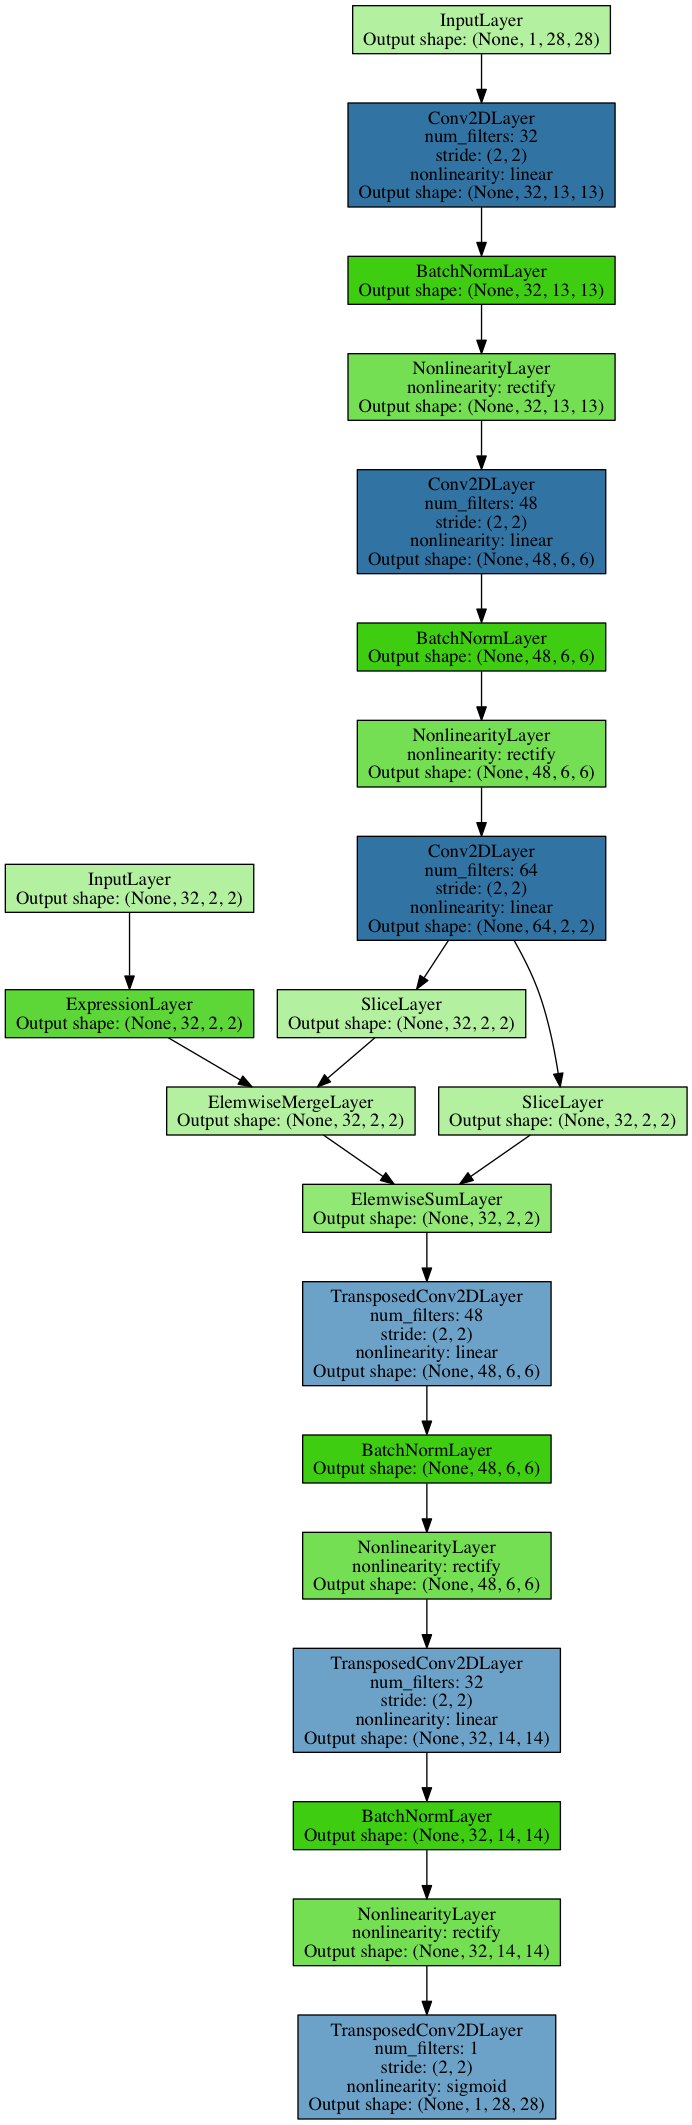

In [530]:
Image("graph.png",width=350)

In [531]:
sampler = lambda bs: np.random.normal(0,1,size=[bs] + list(l_code.output_shape[1::])).astype("float32")

In [629]:
sampler_bv = lambda bs: np.random.normal(0,10,size=[bs] + list(l_code.output_shape[1::])).astype("float32")

In [532]:
print "in ->", l_in.output_shape
print "out ->", l_out.output_shape
print "code ->", l_code.output_shape
print "mean ->", l_mean.output_shape
print "var ->", l_var.output_shape
print "eps ->", l_eps.output_shape

in -> (None, 1, 28, 28)
out -> (None, 1, 28, 28)
code -> (None, 32, 2, 2)
mean -> (None, 32, 2, 2)
var -> (None, 32, 2, 2)
eps -> (None, 32, 2, 2)


In [533]:
x = T.tensor4('x')
z = T.tensor4('z')

In [534]:
net_out, mean_out, var_out, code_out = get_output([l_out, l_mean, l_var, l_code], {l_in:x, l_eps:z})

In [535]:
recon_loss = squared_error(net_out, x)
kl_loss = - 0.5 * T.sum(1 + var_out - T.square(mean_out) - T.exp(var_out), axis=-1)
lambda_=1./784.
tot_loss = recon_loss.mean() + lambda_*kl_loss.mean()

In [536]:
loss_fn = theano.function([x,z], [tot_loss, recon_loss, kl_loss], on_unused_input='warn')

In [537]:
out_fn = theano.function([x,z], net_out, on_unused_input='warn')

In [538]:
net_out_z_only = get_output(l_out, {l_code:z}, deterministic=True)
out_fn_z_only = theano.function([z], net_out_z_only)

In [539]:
net_out_det = get_output(l_out, {l_in:x, l_eps:z}, deterministic=True)
out_fn_det = theano.function([x,z], net_out_det)

--------

In [540]:
def iterator(xx, bs):
    idxs = np.arange(0, xx.shape[0])
    np.random.shuffle(idxs)
    for b in range(xx.shape[0] // bs):
        yield xx[b*bs:(b+1)*bs], sampler(bs)

In [541]:
params = get_all_params(l_out, trainable=True)
params

[W, beta, gamma, W, beta, gamma, W, b, W, beta, gamma, W, beta, gamma, W, b]

In [542]:
updates = adam(tot_loss, params, learning_rate=1e-3)

In [543]:
train_fn = theano.function([x,z], [tot_loss, recon_loss, kl_loss], updates=updates, on_unused_input='warn')

In [544]:
for epoch in range(0,100):
    tot_a,tot_b,tot_c = [], [], []
    for x_batch, z_batch in iterator(X_train, 32):
        aa,bb,cc = train_fn(x_batch, z_batch)
        tot_a.append(aa)
        tot_b.append(bb)
        tot_c.append(cc)
    print epoch+1, np.mean(tot_a), np.mean(tot_b), np.mean(tot_c)

1 0.0122428786081 0.0116690384826 0.449890658376
2 0.00463803982391 0.00439381183152 0.191474746031
3 0.00382258363781 0.00367400519344 0.116485500391
4 0.00344565779016 0.00333429695394 0.0873068956012


KeyboardInterrupt: 

In [351]:
from scipy.stats import norm

In [630]:
def output_grid(xx=None, sampler=sampler, k=1.):
    # display a 2D manifold of the digits
    n = 15  # figure with 15x15 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    for i in range(n):
        for j in range(n):
            if isinstance(xx, np.ndarray):
                x_decoded = out_fn_det(xx, sampler(xx.shape[0])*k)
            else:
                x_decoded = out_fn_z_only(sampler(1)*k)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    return figure

In [583]:
type(None)

NoneType

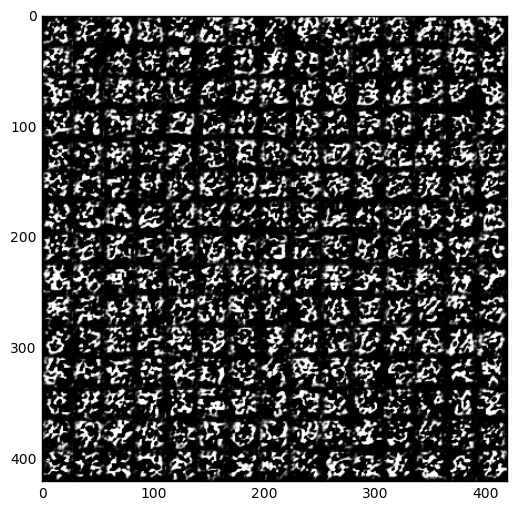

In [597]:
plt.figure(figsize=(6,6))
plt.imshow(output_grid(),cmap="gray")

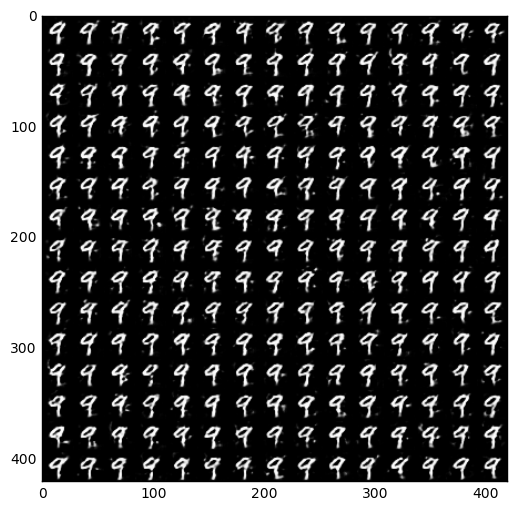

In [638]:
plt.figure(figsize=(6,6))
plt.imshow(output_grid(X_train[4:5], sampler=sampler_bv),cmap="gray")

In [627]:
def random_interp():  
    z1 = sampler(1) 
    z2 = sampler(1)
    c = 0
    row = np.zeros((28, 28*10))
    for j in [0.,.1,.2,.3,.4,.5,.6,.7,.8,.9]:
        out = out_fn_z_only(j*z1 + (1-j)*z2)[0][0]
        row[:,c*28:(c+1)*28] = out
        c += 1
    return row

(-0.5, 279.5, 27.5, -0.5)

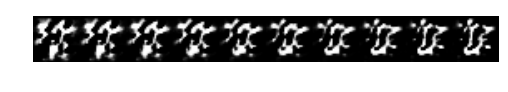

In [628]:
plt.imshow(random_interp(),cmap="gray")
plt.axis('off')

---------